
# Convolutional Neural Network CNN
1. Using Word2Vec implementing CNN model
2. Dispaly Confusion Matrix, precision, recall and F1-score
3. Display few prediction using predict module. 
4. Get 10-fold Average of the CNN model.

In [2]:
from __future__ import division, print_function

# dataframe
import pandas as pd

# numpy array
import numpy as np

# figures visualization
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix 
import seaborn as sns

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

# word2vec
import gensim 
from gensim import models
from gensim.models import Word2Vec 
from gensim.models import KeyedVectors

# CNN model and keras preprocessing
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Dense, Dropout, Reshape, Flatten, concatenate, Input, Conv1D, GlobalMaxPooling1D, Embedding, Conv2D, GlobalMaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# nltk data preprocessing
import nltk
from nltk import word_tokenize
from nltk.tokenize import sent_tokenize 
from nltk.stem import WordNetLemmatizer

# stopword - remove buzz word
from nltk.corpus import stopwords

# splitting data
from sklearn.model_selection import train_test_split

# punctuation - data imbalance
import collections
import re
import string

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

In [6]:
# original english file
filename  = '../../../Data/Fake news detection/data'
df = pd.read_csv(filename + '.csv',  
               delimiter=',')
df.drop(df.columns[[0,1]], axis = 1, inplace = True)

In [7]:
# Run only for English data 
df["Body"] = df["Body"].astype(str)
df["Label"] = df["Label"].astype(str)
data = df

In [8]:
df.head()

,Body,Label
0,Image copyright Getty Images\nOn Sunday mornin...,1
1,"LONDON (Reuters) - “Last Flag Flying”, a comed...",1
2,The feud broke into public view last week when...,1
3,MEXICO CITY (Reuters) - Egypt’s Cheiron Holdin...,1
4,"Country singer Jason Aldean, who was performin...",1


### Class count

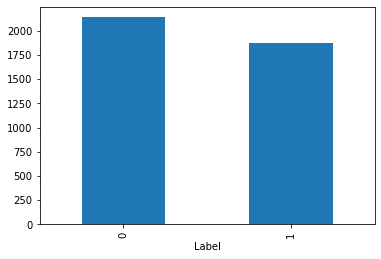

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [10]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

0    2137
1    1872
Name: Label, dtype: int64

In [11]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [12]:
new_text, new_label = balanceClasses(df['Body'], df['Label'])

In [13]:
data = pd.DataFrame(new_text)
data.columns = ['Body']
data['Label'] = new_label
data = pd.concat([df, data])

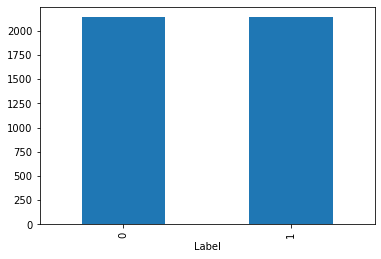

In [14]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Body.count().plot.bar(ylim=0)
plt.show()

In [15]:
data.Label.value_counts()

0    2137
1    2136
Name: Label, dtype: int64

In [16]:
data=data.sample(frac=1).reset_index(drop=True)
data

,Body,Label
0,Game Observations (CLE) by KRL\n% of readers t...,0
1,KABUL (Reuters) - American warplanes in Afghan...,1
2,Texans QB DeShaun Watson Gives His Game Check ...,0
3,Carl Thornton Prepares To Light Up The Dancefl...,0
4,KHARTOUM (Reuters) - Sudanese authorities beli...,1
...,...,...
4268,By Tony Cartalucci\nPerhaps the only thing mor...,0
4269,CAIRO/BEIRUT (Reuters) - A ceasefire deal for ...,1
4270,Artificial intelligence (AI) has become a key ...,1
4271,A Potato Battery Can Light up a Room for Over ...,0


### Data Preprocessing

In [17]:
# People usually join sentences using more than one colon 

def ReplaceDoubleColon(inputString):
    return inputString.replace("..", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceDoubleColon(x))

def ReplaceTripleColon(inputString):
    return inputString.replace("...", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceTripleColon(x))

def ReplaceFourColon(inputString):
    return inputString.replace("....", " ") 

data['Body'] = data['Body'].apply(lambda x: ReplaceFourColon(x))

In [18]:
def textPattern(text):

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r" \n ", " ", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", "have", text)
    text = re.sub(r"can't", "can not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"hadn't", "had not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"mustn't", "must not", text)
    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r"\'re", "are", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\= =", " ", text)
    text = re.sub(r"\==", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"\s{2,}", " ", text)
    return text

data['Body'] = data['Body'].apply(lambda x: textPattern(x))

In [19]:
data.shape

(4273, 2)

In [21]:
# Word Tokenization
tokens = [word_tokenize(sen) for sen in data.Body]

In [22]:
# Lower Case
def lower_token(tokens): 
    return [w.lower() for w in tokens]    
    
lower_tokens = [lower_token(token) for token in tokens]

In [23]:
# Remove Link

def removeLink(token):
    word = []
    for w in token:
        if not w.startswith('http'):
            word.append(w)
    return word 
    
removedLink_tokens = [removeLink(token) for token in lower_tokens]

In [24]:
# Word Lemmatization
def lemmatization(token):
    return [lemmatizer.lemmatize(w) for w in token] 

lemmatizer = WordNetLemmatizer()

lemmatized_tokens = [lemmatization(token) for token in removedLink_tokens]

In [25]:
# Removing Stopwords
stoplist = stopwords.words('english')

In [26]:
def removeStopWords(tokens): 
    return [word for word in tokens if word not in stoplist]

filtered_words = [removeStopWords(sen) for sen in lemmatized_tokens]
data['Text_Final'] = [' '.join(sen) for sen in filtered_words]
data['tokens'] = filtered_words

In [27]:
zero  = []
one = []
for l in data.Label:
    
    if l == '0':
        zero.append(1)
        one.append(0)
    elif l == '1':
        zero.append(0)
        one.append(1)
        
data['0']= zero
data['1']= one

data = data[['Text_Final', 'tokens', 'Label', '0', '1']]

In [28]:
category_id = []
for l in data.Label:
    
    if l == '0':
        category_id.append('0')
    elif l == '1':
        category_id.append('1')
        
data['Category_id'] = category_id

data = data[['Text_Final', 'tokens', 'Label', '0', '1', 'Category_id' ]]
data.head(9)

,Text_Final,tokens,Label,0,1,Category_id
0,game observation cle krl reader think story fa...,"[game, observation, cle, krl, reader, think, s...",0,1,0,0
1,kabul reuters - american warplane afghanistan ...,"[kabul, reuters, -, american, warplane, afghan...",1,0,1,1
2,texan qb deshaun watson give game check three ...,"[texan, qb, deshaun, watson, give, game, check...",0,1,0,0
3,carl thornton prepares light dancefloor summer...,"[carl, thornton, prepares, light, dancefloor, ...",0,1,0,0
4,khartoum reuters - sudanese authority believe ...,"[khartoum, reuters, -, sudanese, authority, be...",1,0,1,1
5,cnn one wa man died shielding wife gunfire wed...,"[cnn, one, wa, man, died, shielding, wife, gun...",1,0,1,1
6,electronic board display count vote lower hous...,"[electronic, board, display, count, vote, lowe...",1,0,1,1
7,active shooter reported near la vega casino re...,"[active, shooter, reported, near, la, vega, ca...",0,1,0,0
8,red flag warning : california wildfire among d...,"[red, flag, warning, :, california, wildfire, ...",0,1,0,0


In [29]:
data = data[data.tokens != '']

In [30]:
from io import StringIO
category_id_df = data[['Label', 'Category_id']].drop_duplicates().sort_values('Category_id')
category_to_label_dict = dict(category_id_df.values)
label_to_category_dict = dict(category_id_df[['Category_id', 'Label']].values)

#### Split Data into test and train
We will use 90 % data for training and 10 % for testing. We use random state so every time we get the same training and testing data.

In [31]:
data.shape

(4273, 6)

In [32]:
data_train, data_test = train_test_split(data, test_size=0.10, shuffle = True)


In [33]:
# # total training words
totalTrainingWords = [word for tokens in data_train["tokens"] for word in tokens]

# # Storing Length of the training sentence
lengthTrainingSentences = [len(tokens) for tokens in data_train["tokens"]]

# # training Vocabulary size
trainingVocabSize = sorted(list(set(totalTrainingWords)))

## Total number of lines
linesCount = len(data_train["tokens"])

### Load Google Word2vec model

In [34]:
word2vec_path = 'GoogleNews-vectors-negative300.bin'

In [35]:
from gensim import models
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)


In [36]:
word2vec

In [37]:
MAX_SEQUENCE_LENGTH = 150
EMBEDDING_DIM = 300


### Tokenize and Pad sequences

In [38]:
tokenizer = Tokenizer(num_words=len(trainingVocabSize), lower=True, char_level=False)
tokenizer.fit_on_texts(data_train["Text_Final"].tolist())
training_sequences = tokenizer.texts_to_sequences(data_train["Text_Final"].tolist())

train_word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(train_word_index))

Found 39935 unique tokens.


In [39]:
cnnTrainData = pad_sequences(training_sequences, maxlen=MAX_SEQUENCE_LENGTH)

In [40]:
train_embedding_weights = np.zeros((len(train_word_index)+1, EMBEDDING_DIM))
for word,index in train_word_index.items():
    train_embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(train_embedding_weights.shape)

(39936, 300)


In [41]:
test_sequences = tokenizer.texts_to_sequences(data_test["Text_Final"].tolist())
cnnTestData = pad_sequences(test_sequences, maxlen= MAX_SEQUENCE_LENGTH)

### Define CNN

The model is from the paper 'Convolutional Neural Networks for Sentence Classification' we have updated the network according to our requirement [1]

In [42]:
label_names = ['0', '1']

In [43]:
from tensorflow.keras import optimizers
def ConvolutionalNeuralNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index):
    
    # Embedding layer
    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=False)
    
    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    convs = []
    
    #Kernal (window) size
    filter_sizes = [2,3,4,5]

    # Convolution Layer and max-pooling
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=512, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = GlobalMaxPooling1D()(l_conv)
        convs.append(l_pool)
        
    l_merge = concatenate(convs, axis=1)
    
    # softmax layer for multiclass identification 
    x = Dropout(0.1)(l_merge)  
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss= 'categorical_crossentropy',
                 optimizer = optimizers.RMSprop(learning_rate=1e-3),
#                    optimizer='adam',
                  metrics=['accuracy'])
    return model

In [44]:
# Splitting train data into X_train and y_train
y_train = data_train[label_names].values
x_train = cnnTrainData
y_tr = y_train

In [45]:
# Splitting train data into X_test and y_test
y_test = data_test[label_names].values
x_test = cnnTestData
y_tst = y_test

In [46]:
model = ConvolutionalNeuralNet(train_embedding_weights, MAX_SEQUENCE_LENGTH, len(train_word_index)+1, EMBEDDING_DIM, len(list(label_names)))

In [47]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 150, 300)     11980800    input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 149, 512)     307712      embedding[0][0]                  
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 148, 512)     461312      embedding[0][0]                  
_______________________________________________________________________________________

### Train CNN

In [48]:
num_epochs = 10
batch_size = 32

In [49]:
history = model.fit(x_train, y_tr, epochs=num_epochs, validation_split=0.1, shuffle=True, batch_size=batch_size)

Epoch 1/10
109/109 [==============================] - 59s 542ms/step - loss: 0.6150 - accuracy: 0.8220 - val_loss: 0.0986 - val_accuracy: 0.9688
Epoch 2/10
109/109 [==============================] - 56s 513ms/step - loss: 0.0852 - accuracy: 0.9711 - val_loss: 0.0651 - val_accuracy: 0.9766
Epoch 3/10
109/109 [==============================] - 50s 456ms/step - loss: 0.0467 - accuracy: 0.9870 - val_loss: 0.1567 - val_accuracy: 0.9636
Epoch 4/10
109/109 [==============================] - 49s 452ms/step - loss: 0.0394 - accuracy: 0.9893 - val_loss: 1.2608 - val_accuracy: 0.8805
Epoch 5/10
109/109 [==============================] - 57s 522ms/step - loss: 0.0069 - accuracy: 0.9977 - val_loss: 0.0961 - val_accuracy: 0.9818
Epoch 6/10
109/109 [==============================] - 53s 490ms/step - loss: 0.0319 - accuracy: 0.9942 - val_loss: 0.1723 - val_accuracy: 0.9688
Epoch 7/10
109/109 [==============================] - 53s 487ms/step - loss: 0.0144 - accuracy: 0.9962 - val_loss: 0.1030 - val_ac

In [50]:
# evaluate on train data
results = model.evaluate(x_train, y_tr)

121/121 [==============================] - 26s 217ms/step - loss: 0.0206 - accuracy: 0.9964


In [51]:
# evaluate on test data
results = model.evaluate(x_test, y_tst)

14/14 [==============================] - 2s 164ms/step - loss: 0.1011 - accuracy: 0.9790


In [52]:
# predict model
predictions = model.predict(cnnTestData, batch_size=1024, verbose=1)

1/1 [==============================] - 0s 5ms/step


### Testing few sentences using our model

In [53]:

labels = ['0', '1']

def makeprediction(texts):
    tk = Tokenizer()
    tk.fit_on_texts(texts)
    index_list = tk.texts_to_sequences(texts)
    x_train = pad_sequences(index_list, maxlen=150)
    pred = model.predict(x_train)
    result = labels[np.argmax(pred)]
    return result

In [54]:
prediction_labels=[]
for p in predictions:
    prediction_labels.append(labels[np.argmax(p)])

In [55]:
sum(data_test.Label==prediction_labels)/len(prediction_labels)

0.9789719626168224

In [56]:
data_test.Label.value_counts()

1    219
0    209
Name: Label, dtype: int64

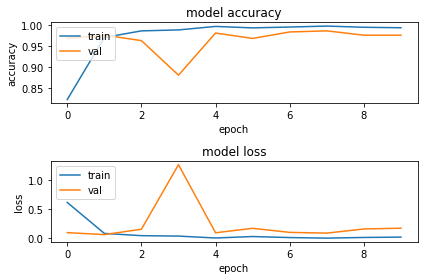

In [57]:
plt.figure(1)
# summarize history for accuracy
plt.subplot(211)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
# summarize history for loss
plt.subplot(212)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout()
plt.show()

In [58]:
results = confusion_matrix(data_test.Label, prediction_labels)
print ('Confusion Matrix :')
print(results) 
print ('Accuracy Score :',accuracy_score(data_test.Label, prediction_labels))
print ('Report : ')
print (classification_report(data_test.Label, prediction_labels))

Confusion Matrix :
[[203   6]
 [  3 216]]
Accuracy Score : 0.9789719626168224
Report : 
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       209
           1       0.97      0.99      0.98       219

    accuracy                           0.98       428
   macro avg       0.98      0.98      0.98       428
weighted avg       0.98      0.98      0.98       428



                        Convolution Neural Network


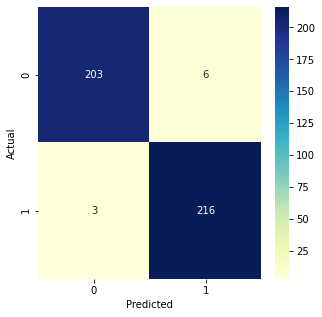

In [59]:
from sklearn.metrics import confusion_matrix
print("                        Convolution Neural Network")
conf_mat = confusion_matrix(data_test.Label, prediction_labels)
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap ='YlGnBu',
            xticklabels=category_id_df.Label.values, yticklabels=category_id_df.Label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

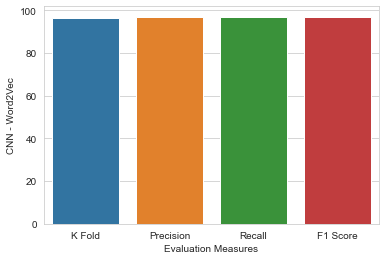

In [60]:
# for Word2Vec
import pandas as pd
import seaborn as sns
results=pd.DataFrame()
dictionary=dict()
dictionary['Evaluation Measures']=["K Fold", "Precision", "Recall", "F1 Score"]
dictionary['CNN - Word2Vec']=[96.4, 97, 97, 97]
results=pd.DataFrame(dictionary)
sns.set_style(style="whitegrid")
ax = sns.barplot(x='Evaluation Measures', y= 'CNN - Word2Vec',data=results)

### Reference
[1] "Convolutional Neural Networks for Sentence Classification" by Yoon Kim
